跟 RAG Fusion 类似，MultiQuery 是一种通过生成多种视角的查询来检索相关文档的方法。它使用 LLM 从用户输入的查询生成多个不同的查询视角，然后为每个查询检索一组相关文档，并合并这些结果以获得更全面的文档集合。
跟 RAG Fusion 不同的是，MultiQuery 没有使用 RRF 来融合多个搜索结果列表的排名，而是将多个搜索结果放到 context 中。这样做的好处是能够在上下文中保留更多的检索结果，提供更丰富的信息源，同时减少了在排名融合上的复杂性。通过这种方法，用户可以获得更加多样化和全面的信息集合，有助于更好地理解和回答复杂的问题。

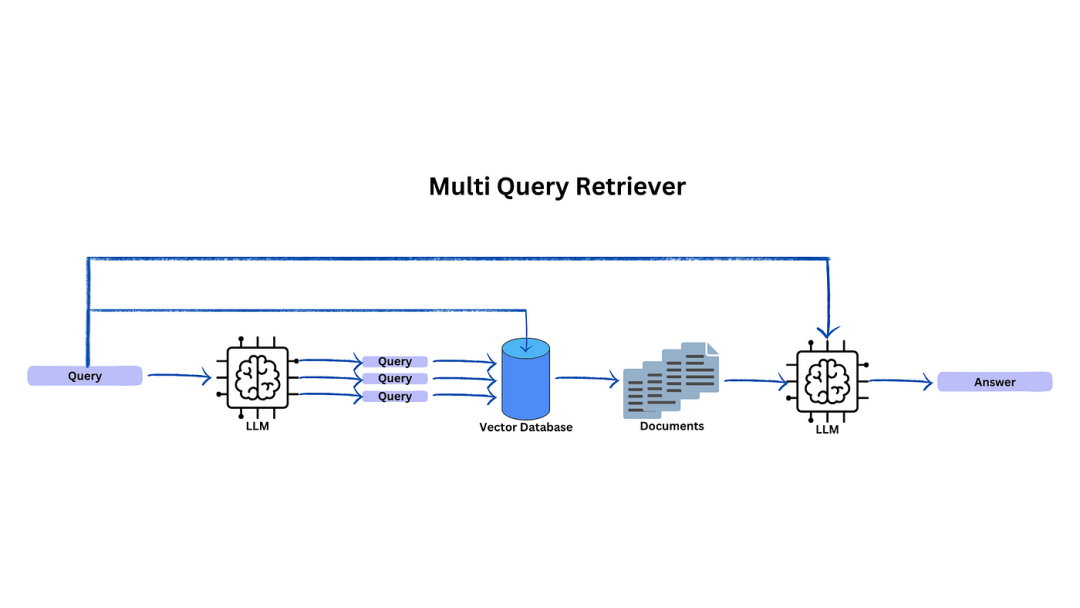

In [ ]:
%pip install langchain langchain_community openai chromadb tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.5/973.5 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.1/324.1 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.2/310.2 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.4/124.4 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-

In [ ]:
#-------------------------------Prepare Vector Database----------------------
# Build a sample vectorDB
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
import os

In [ ]:
# 设置OpenAI KEY环境变量
import os
import getpass
os.environ['OPENAI_API_KEY'] = getpass.getpass('OpenAI API Key:')

OpenAI API Key:··········


In [ ]:
# Load blog post
loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
data = loader.load()

In [ ]:
# Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size=100, chunk_overlap=0)
splits = text_splitter.split_documents(data)
print(len(splits))

570


In [ ]:
# VectorDB
embedding = OpenAIEmbeddings()
vectordb = Chroma.from_documents(documents=splits, embedding=embedding)

In [ ]:
#---------------------------Prepare Multi Query Retriever--------------------
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain.chat_models import ChatOpenAI

In [ ]:
question = "What are the approaches to Task Decomposition?"
llm = ChatOpenAI(temperature=0)
retriever_from_llm = MultiQueryRetriever.from_llm(retriever=vectordb.as_retriever(), llm=llm)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


In [ ]:
#----------------------Setup QnA----------------------------------------
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate

In [ ]:
qa_system_prompt = """
        Use the following pieces of retrieved context to answer the question. \        If you don't know the answer, just say that you don't know. \
        {context}"""

qa_prompt = ChatPromptTemplate.from_messages([("system", qa_system_prompt),("human", "{question}"),])

In [ ]:
def format_docs(docs):
    doc_strings = [doc.page_content for doc in docs]
    return "\n\n".join(doc_strings)

In [ ]:
rag_chain = ({"context": retriever_from_llm
    | format_docs, "question": RunnablePassthrough()}
    | qa_prompt
    | llm
    | StrOutputParser())

rag_chain.invoke("What are the approaches to Task Decomposition?")

'There are several approaches to task decomposition, including:\n\n1. Hierarchical Task Analysis (HTA): This approach breaks down tasks into sub-tasks in a hierarchical manner, showing the relationships between different levels of tasks.\n\n2. Object-Oriented Task Analysis (OOT): This approach focuses on the objects involved in a task and how they interact with each other to achieve the task.\n\n3. Function Allocation: This approach involves assigning different functions or sub-tasks to different agents or components based on their capabilities and expertise.\n\n4. Cognitive Task Analysis (CTA): This approach focuses on understanding the cognitive processes involved in performing a task and breaking it down into smaller cognitive sub-tasks.\n\n5. Goal Decomposition: This approach involves breaking down a task into smaller goals or objectives that need to be achieved to complete the task.\n\nEach approach has its own strengths and weaknesses, and the choice of approach depends on the na